In [118]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score,mean_absolute_error,classification_report
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers, models
from skimage import color
from skimage import filters
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, LeakyReLU


# Model to examine
model = tf.keras.models.load_model('CNNmodel8000_lr0001_race.h5')

In [115]:
# Choose the label type
Labeltype = 'race'
samplesize = 8000
replacev = False
Nlabels = -1
if(Labeltype == 'age'):
    Nlabels = 9
if(Labeltype == 'gender'):
    Nlabels = 2
if(Labeltype == 'race'):
    Nlabels = 5

### Get the file paths and labels
### Split into train-test-validate
### Balance the train paths and labels

In [116]:
# Import image labels and paths to dataframe
mypath = "../data/raw/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=2)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train_2)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train_2).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 10000
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(samplesize/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples, replace = replacev)).sample(frac=1)

# Count and print prebalanced classes
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets (Total should be 10000)
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=4, n=1348 (7.108%)
Class=3, n=3183 (16.784%)
Class=0, n=8048 (42.438%)
Class=1, n=3643 (19.210%)
Class=2, n=2742 (14.459%)
Class=3, n=6014 (20.000%)
Class=1, n=6014 (20.000%)
Class=2, n=6014 (20.000%)
Class=0, n=6014 (20.000%)
Class=4, n=6014 (20.000%)
Class=3, n=1600 (20.000%)
Class=2, n=1600 (20.000%)
Class=4, n=1600 (20.000%)
Class=1, n=1600 (20.000%)
Class=0, n=1600 (20.000%)


### Function to get images

In [117]:
def get_images(filelist,rgb = True):
    dims = 0
    if(rgb):
        dims=3
    else:
        dims=1
    container = np.zeros((len(filelist),200,200,dims),dtype = np.int16)
    for index,i in enumerate(filelist):
        img = cv2.imread(i)
        if(not rgb):
            img = color.rgb2gray(img)
        container[index,:,:,:dims]=img
    return container

In [119]:
test_img_container = get_images(X_test,rgb = True)

In [120]:
ypredtest = model.predict(test_img_container)

149/149 [==============================] - 21s 143ms/step


In [121]:
incorrects = np.argmax(ypredtest,axis=-1) != y_test

In [122]:
IncorrectAge = pd.DataFrame(data = y_test)

In [123]:
IncorrectAge['predrace'] = np.argmax(ypredtest,axis=-1)

In [124]:
IncorrectAge['correct'] = IncorrectAge['predrace'] == IncorrectAge['race']

In [125]:
IncorrectAge['file'] = X_test

In [126]:
IncorrectAges = IncorrectAge[IncorrectAge['correct']==False]

In [127]:
correctAges = IncorrectAge[IncorrectAge.correct == True]

In [128]:
correctAgesSingle = correctAges.drop_duplicates(subset=['race', 'predrace'], keep='first')

In [129]:
IncorrectAgesSingle = IncorrectAges.drop_duplicates(subset=['race', 'predrace'], keep='first')

In [130]:
correctAgesSingle.head()

,race,predrace,correct,file
4909,3,3,True,../data/raw/CroppedImages/24_1_3_2017011917102...
16116,2,2,True,../data/raw/CroppedImages/42_0_2_2017010419284...
577,0,0,True,../data/raw/CroppedImages/14_1_0_2017010921265...
11300,1,1,True,../data/raw/CroppedImages/31_0_1_2017011317340...
4128,4,4,True,../data/raw/CroppedImages/23_1_4_2017011719424...


In [131]:
correctagefiles = correctAgesSingle['file'].values

In [132]:
IncorrectAgesSingle.head()

,race,predrace,correct,file
15988,3,1,False,../data/raw/CroppedImages/41_1_3_2017010423581...
2070,3,4,False,../data/raw/CroppedImages/1_0_3_20161219230351...
14171,0,3,False,../data/raw/CroppedImages/37_0_0_2017010418522...
2796,0,4,False,../data/raw/CroppedImages/20_1_0_2017010320173...
2179,4,2,False,../data/raw/CroppedImages/1_0_4_20161221202132...


In [135]:
incorrectagefiles = IncorrectAgesSingle['file'][:5].values

In [136]:
incorrectagefiles

array(['../data/raw/CroppedImages/41_1_3_20170104235812019.jpg.chip.jpg',
       '../data/raw/CroppedImages/1_0_3_20161219230351288.jpg.chip.jpg',
       '../data/raw/CroppedImages/37_0_0_20170104185229157.jpg.chip.jpg',
       '../data/raw/CroppedImages/20_1_0_20170103201733831.jpg.chip.jpg',
       '../data/raw/CroppedImages/1_0_4_20161221202132305.jpg.chip.jpg'],
      dtype=object)

In [137]:
correctageimagearray = get_images(correctagefiles)

In [138]:
incorrectageimagearray = get_images(incorrectagefiles)

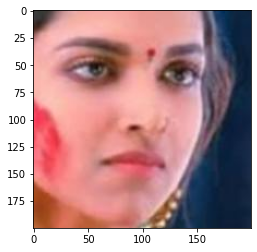

In [139]:
plt.imshow(correctageimagearray[0][:,:,::-1])

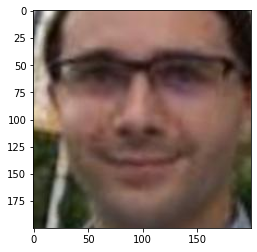

In [141]:
plt.imshow(incorrectageimagearray[2][:,:,::-1])

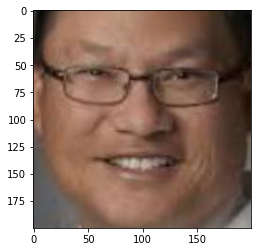

In [142]:
plt.imshow(correctageimagearray[1][:,:,::-1])

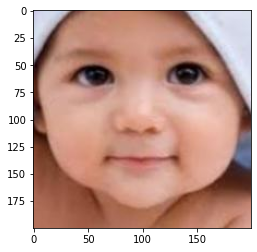

In [143]:
plt.imshow(incorrectageimagearray[4][:,:,::-1])

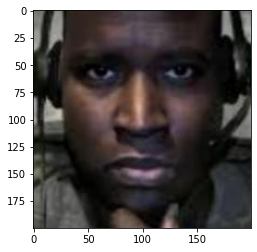

In [144]:
plt.imshow(correctageimagearray[3][:,:,::-1])

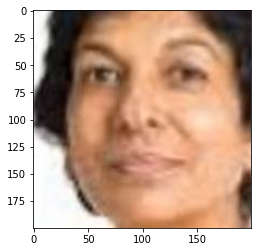

In [145]:
plt.imshow(incorrectageimagearray[0][:,:,::-1])